In [2]:
"""
This script uses msprime to simulate under an isolation with migration model,
writing the outputs to VCF. We'll simulate a small dataset: 100 x 1Mb regions,
each with recombination and mutation rates of 1.5e-8. We'll then use moments
to compute LD statistics from each of the 100 replicates to compute statistic
means and variances/covariances. These are then used to refit the simulated
model using moments.LD, and then we use bootstrapped datasets to estimate
confidence intervals.

The demographic model is a population of size 10,000 that splits into a
population of size 2,000 and a population of size 20,000. The split occurs
1,500 generations ago followed by symmetric migration at rate 1e-4.
"""

import os
import time
import gzip
import numpy as np
import pickle
import msprime
import moments
import demes
import ray
import json

assert msprime.__version__ >= "1"

if not os.path.isdir("./data/"):
    os.makedirs("./data/")
os.system("rm ./data/*.vcf.gz")
os.system("rm ./data/*.h5")

upper_bound_params = {
    "t_split": 5000, 
    "m": 1e-4,
    "N1": 10000,
    "N2": 10000,
    "Na": 20000
}

lower_bound_params =  {
    "t_split": 100, 
    "m": 1e-8,
    "N1": 100,
    "N2": 100,
    "Na": 10000

}

def sample_params():
    sampled_params = {}
    for key in lower_bound_params:
        lower_bound = lower_bound_params[key]
        upper_bound = upper_bound_params[key]
        sampled_value = np.random.uniform(lower_bound, upper_bound)

        # Initialize adjusted_value with sampled_value by default
        adjusted_value = sampled_value

        # Check if the sampled parameter is equal to the mean of the uniform distribution
        mean_value = (lower_bound + upper_bound) / 2
        if sampled_value == mean_value:
            # Add a small random value to avoid exact mean, while keeping within bounds
            adjustment = np.random.uniform(-0.1 * (upper_bound - lower_bound), 0.1 * (upper_bound - lower_bound))
            adjusted_value = sampled_value + adjustment
            # Ensure the adjusted value is still within the bounds
            adjusted_value = max(min(adjusted_value, upper_bound), lower_bound)

        # Assign adjusted_value to sampled_params
        if key == "m":
            sampled_params[key] = adjusted_value
        else:
            sampled_params[key] = int(adjusted_value)

    return sampled_params

def demographic_model(sampled_params):

    # Unpack the sampled parameters
    Na, N1, N2, m, t_split = (
        sampled_params["Na"],  # Effective population size of the ancestral population
        sampled_params["N1"],  # Size of population 1 after split
        sampled_params["N2"],  # Size of population 2 after split
        sampled_params["m"],   # Migration rate between populations
        sampled_params["t_split"],  # Time of the population split (in generations)
    )

    b = demes.Builder()
    b.add_deme("Na", epochs=[dict(start_size=Na, end_time=t_split)])
    b.add_deme("N1", ancestors=["Na"], epochs=[dict(start_size=N1)])
    b.add_deme("N2", ancestors=["Na"], epochs=[dict(start_size=N2)])
    b.add_migration(demes=["N1", "N2"], rate=m)
    g = b.resolve()
    return g

# def demographic_model():
#     b = demes.Builder()
#     b.add_deme("Na", epochs=[dict(start_size=18575, end_time=1408)])
#     b.add_deme("N1", ancestors=["Na"], epochs=[dict(start_size=617)])
#     b.add_deme("N2", ancestors=["Na"], epochs=[dict(start_size=4559)])
#     b.add_migration(demes=["N1", "N2"], rate=7.701758925243914e-05)
#     g = b.resolve()
#     return g

# def run_msprime_replicates(experiment_config, num_reps=100):
#     # Set up the demography from demes
#     g = demographic_model()
#     demog = msprime.Demography.from_demes(g)

#     # Dynamically define the samples using msprime.SampleSet, based on the sample_sizes dictionary
#     samples = [
#         msprime.SampleSet(sample_size, population=pop_name, ploidy=1)
#         for pop_name, sample_size in experiment_config['num_samples'].items()
#     ]

#     tree_sequences = msprime.sim_ancestry(
#         samples,
#         demography=demog,
#         sequence_length=experiment_config['genome_length'],
#         recombination_rate=experiment_config['recombination_rate'],
#         num_replicates=num_reps,
#         random_seed=42,
#     )
#     for ii, ts in enumerate(tree_sequences):
#         ts = msprime.sim_mutations(ts, rate=experiment_config['mutation_rate'], random_seed=ii + 1)
#         vcf_name = "./data/split_mig.{0}.vcf".format(ii)
#         with open(vcf_name, "w+") as fout:
#             ts.write_vcf(fout, allow_position_zero=True)
#         os.system(f"gzip {vcf_name}")


def run_msprime_replicates(sampled_params, experiment_config):

    g = demographic_model(sampled_params)
    demog = msprime.Demography.from_demes(g)
    tree_sequences = msprime.sim_ancestry(
        {"N1": experiment_config['num_samples']['N1'], "N2": experiment_config['num_samples']['N2']},
        demography=demog,
        sequence_length=experiment_config['genome_length'],
        recombination_rate=experiment_config['recombination_rate'],
        num_replicates=experiment_config['num_reps'],
        random_seed=experiment_config['seed'],
    )
    for ii, ts in enumerate(tree_sequences):
        ts = msprime.sim_mutations(ts, rate=experiment_config['mutation_rate'], random_seed=ii + 1)
        vcf_name = "./data/split_mig.{0}.vcf".format(ii)
        with open(vcf_name, "w+") as fout:
            ts.write_vcf(fout, allow_position_zero=True)
        os.system(f"gzip {vcf_name}")

def write_samples_and_rec_map(experiment_config):

    # Define the file paths
    samples_file = "./data/samples.txt"
    flat_map_file ="./data/flat_map.txt"

    # Open and write the sample file
    with open(samples_file, "w+") as fout:
        fout.write("sample\tpop\n")

        # Dynamically define samples based on the num_samples dictionary
        sample_idx = 0  # Initialize sample index
        for pop_name, sample_size in experiment_config['num_samples'].items():
            for _ in range(sample_size):
                fout.write(f"tsk_{sample_idx}\t{pop_name}\n")
                sample_idx += 1

    # Write the recombination map file
    with open(flat_map_file, "w+") as fout:
        fout.write("pos\tMap(cM)\n")
        fout.write("0\t0\n")
        fout.write(f"{experiment_config['genome_length']}\t{experiment_config['recombination_rate'] * experiment_config['genome_length'] * 100}\n")

# def write_samples_and_rec_map(L=1000000, r=1.5e-8, n=18):
#     # samples file
#     with open("./data/samples.txt", "w+") as fout:
#         fout.write("sample\tpop\n")
#         for jj in range(2):
#             for ii in range(n):
#                 fout.write(f"tsk_{jj * n + ii}\tdeme{jj}\n")
#     # recombination map
#     with open("./data/flat_map.txt", "w+") as fout:
#         fout.write("pos\tMap(cM)\n")
#         fout.write("0\t0\n")
#         fout.write(f"{L}\t{r * L * 100}\n")

# Define your function with Ray's remote decorator
@ray.remote
def get_LD_stats(rep_ii, r_bins):
    vcf_file = f"./data/split_mig.{rep_ii}.vcf.gz"
    time1 = time.time()
    ld_stats = moments.LD.Parsing.compute_ld_statistics(
        vcf_file,
        rec_map_file="./data/flat_map.txt",
        pop_file="./data/samples.txt",
        pops=["N1", "N2"],
        r_bins=r_bins,
        report=False,
    )
    time2 = time.time()
    print("  finished rep", rep_ii, "in", int(time2 - time1), "seconds")
    return ld_stats


if __name__ == "__main__":
    num_reps = 100
    # define the bin edges
    r_bins = np.array([0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3])

    with open("/sietch_colab/akapoor/Demographic_Inference/experiment_config.json") as f:
        experiment_config = json.load(f)


    # Initialize Ray
    ray.init(ignore_reinit_error=True)

    # Sample parameters
    sampled_params = sample_params()

    print("running msprime and writing vcfs")
    run_msprime_replicates(sampled_params, experiment_config)
    # run_msprime_replicates(experiment_config=experiment_config, num_reps=num_reps)

    print("writing samples and recombination map")
    write_samples_and_rec_map(experiment_config=experiment_config)

    print("parsing LD statistics in parallel")
    # Submit tasks to Ray in parallel using .remote()
    futures = [get_LD_stats.remote(ii, r_bins) for ii in range(num_reps)]
    # Gather results with ray.get() to collect them once the tasks are finished
    ld_stats = ray.get(futures)
    # Optionally, you can convert the list of results into a dictionary with indices
    ld_stats_dict = {ii: result for ii, result in enumerate(ld_stats)}

    print("computing mean and varcov matrix from LD statistics sums")
    mv = moments.LD.Parsing.bootstrap_data(ld_stats_dict)
    with open(f"./data/means.varcovs.split_mig.{num_reps}_reps.bp", "wb+") as fout:
        pickle.dump(mv, fout)
    print(
        "computing bootstrap replicates of mean statistics (for confidence intervals"
    )
    all_boot = moments.LD.Parsing.get_bootstrap_sets(ld_stats_dict)
    with open(f"./data/bootstrap_sets.split_mig.{num_reps}_reps.bp", "wb+") as fout:
        pickle.dump(all_boot, fout)
    os.system("rm ./data/*.vcf.gz")
    os.system("rm ./data/*.h5")

# print("computing expectations under the model")
g = demographic_model(sampled_params)
# y = moments.Demes.LD(g, sampled_demes=["deme0", "deme1"], rho=4 * 10000 * r_bins)
# y = moments.LD.LDstats(
#     [(y_l + y_r) / 2 for y_l, y_r in zip(y[:-2], y[1:-1])] + [y[-1]],
#     num_pops=y.num_pops,
#     pop_ids=y.pop_ids,
# )
# y = moments.LD.Inference.sigmaD2(y)

# plot simulated data vs expectations under the model
# fig = moments.LD.Plotting.plot_ld_curves_comp(
#     y,
#     mv["means"][:-1],
#     mv["varcovs"][:-1],
#     rs=r_bins,
#     stats_to_plot=[
#         ["DD_0_0"],
#         ["DD_0_1"],
#         ["DD_1_1"],
#         ["Dz_0_0_0"],
#         ["Dz_0_1_1"],
#         ["Dz_1_1_1"],
#         ["pi2_0_0_1_1"],
#         ["pi2_0_1_0_1"],
#         ["pi2_1_1_1_1"],
#     ],
#     labels=[
#         [r"$D_0^2$"],
#         [r"$D_0 D_1$"],
#         [r"$D_1^2$"],
#         [r"$Dz_{0,0,0}$"],
#         [r"$Dz_{0,1,1}$"],
#         [r"$Dz_{1,1,1}$"],
#         [r"$\pi_{2;0,0,1,1}$"],
#         [r"$\pi_{2;0,1,0,1}$"],
#         [r"$\pi_{2;1,1,1,1}$"],
#     ],
#     rows=3,
#     plot_vcs=True,
#     show=False,
#     fig_size=(6, 4),
#     output="split_mig_comparison.pdf",
# )

print("running inference")
# Run inference using the parsed data
demo_func = moments.LD.Demographics2D.split_mig
# Set up the initial guess
# The split_mig function takes four parameters (nu0, nu1, T, m), and we append
# the last parameter to fit Ne, which doesn't get passed to the function but
# scales recombination rates so can be simultaneously fit
p_guess = [0.1, 2, 0.075, 2, 10000]
p_guess = moments.LD.Util.perturb_params(p_guess, fold=0.1)
opt_params, LL = moments.LD.Inference.optimize_log_lbfgsb(
    p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins,
)

physical_units = moments.LD.Util.rescale_params(
    opt_params, ["nu", "nu", "T", "m", "Ne"]
)

print("Simulated parameters:")
print(f"  N(deme0)         :  {g.demes[1].epochs[0].start_size:.1f}")
print(f"  N(deme1)         :  {g.demes[2].epochs[0].start_size:.1f}")
print(f"  Div. time (gen)  :  {g.demes[1].epochs[0].start_time:.1f}")
print(f"  Migration rate   :  {g.migrations[0].rate:.6f}")
print(f"  N(ancestral)     :  {g.demes[0].epochs[0].start_size:.1f}")

print("best fit parameters:")
print(f"  N(deme0)         :  {physical_units[0]:.1f}")
print(f"  N(deme1)         :  {physical_units[1]:.1f}")
print(f"  Div. time (gen)  :  {physical_units[2]:.1f}")
print(f"  Migration rate   :  {physical_units[3]:.6f}")
print(f"  N(ancestral)     :  {physical_units[4]:.1f}")

    # print("computing confidence intervals for parameters")
    # uncerts = moments.LD.Godambe.GIM_uncert(
    #     demo_func, all_boot, opt_params, mv["means"], mv["varcovs"], r_edges=r_bins,
    # )

    # lower = opt_params - 1.96 * uncerts
    # upper = opt_params + 1.96 * uncerts

    # lower_pu = moments.LD.Util.rescale_params(lower, ["nu", "nu", "T", "m", "Ne"])
    # upper_pu = moments.LD.Util.rescale_params(upper, ["nu", "nu", "T", "m", "Ne"])

    # print("95% CIs:")
    # print(f"  N(deme0)         :  {lower_pu[0]:.1f} - {upper_pu[0]:.1f}")
    # print(f"  N(deme1)         :  {lower_pu[1]:.1f} - {upper_pu[1]:.1f}")
    # print(f"  Div. time (gen)  :  {lower_pu[2]:.1f} - {upper_pu[2]:.1f}")
    # print(f"  Migration rate   :  {lower_pu[3]:.6f} - {upper_pu[3]:.6f}")
    # print(f"  N(ancestral)     :  {lower_pu[4]:.1f} - {upper_pu[4]:.1f}")

rm: cannot remove './data/*.vcf.gz': No such file or directory
rm: cannot remove './data/*.h5': No such file or directory
2024-11-05 12:46:50,306	INFO worker.py:1614 -- Calling ray.init() again after it has already been called.


running msprime and writing vcfs
writing samples and recombination map
parsing LD statistics in parallel
computing mean and varcov matrix from LD statistics sums
computing bootstrap replicates of mean statistics (for confidence intervals
running inference
Simulated parameters:
  N(deme0)         :  2113.0
  N(deme1)         :  8844.0
  Div. time (gen)  :  4987.0
  Migration rate   :  0.000008
  N(ancestral)     :  14934.0
best fit parameters:
  N(deme0)         :  2065.7
  N(deme1)         :  8926.2
  Div. time (gen)  :  4845.5
  Migration rate   :  0.000008
  N(ancestral)     :  15226.5


In [3]:
print("best fit parameters:")
print(f"  N(deme0)         :  {physical_units[0]:.1f}")
print(f"  N(deme1)         :  {physical_units[1]:.1f}")
print(f"  Div. time (gen)  :  {physical_units[2]:.1f}")
print(f"  Migration rate   :  {physical_units[3]:.6f}")
print(f"  N(ancestral)     :  {physical_units[4]:.1f}")

best fit parameters:
  N(deme0)         :  2065.7
  N(deme1)         :  8926.2
  Div. time (gen)  :  4845.5
  Migration rate   :  0.000008
  N(ancestral)     :  15226.5


## Let's load the mv object and see what's up

In [4]:
with open('/sietch_colab/akapoor/Demographic_Inference/notebooks/data/means.varcovs.split_mig.100_reps.bp', 'rb') as f:
    mv = pickle.load(f)

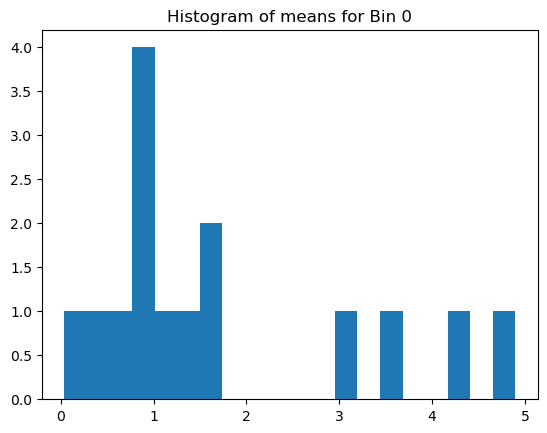

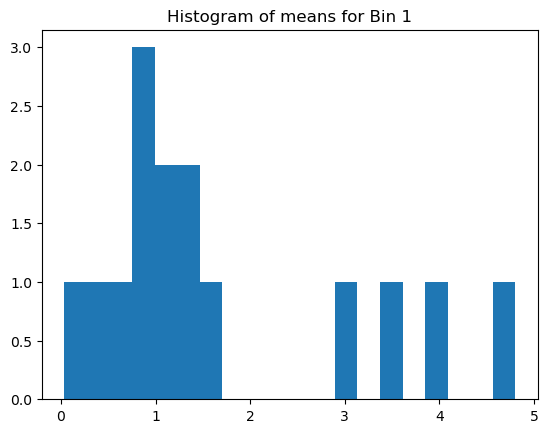

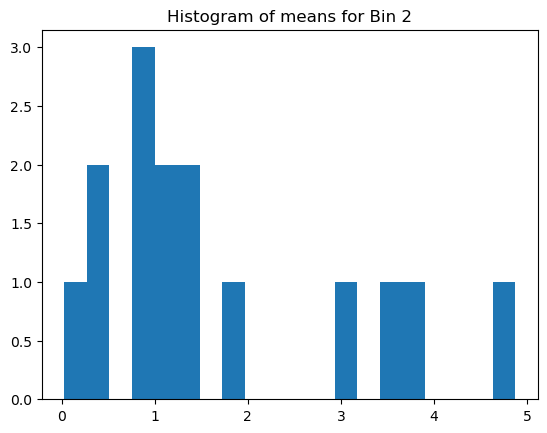

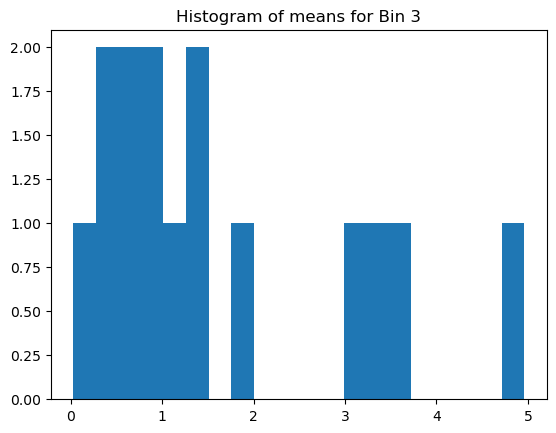

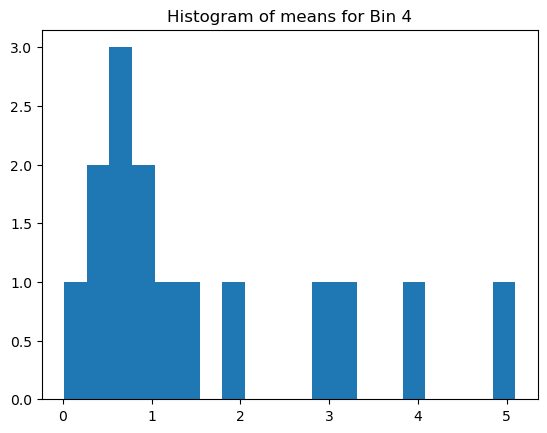

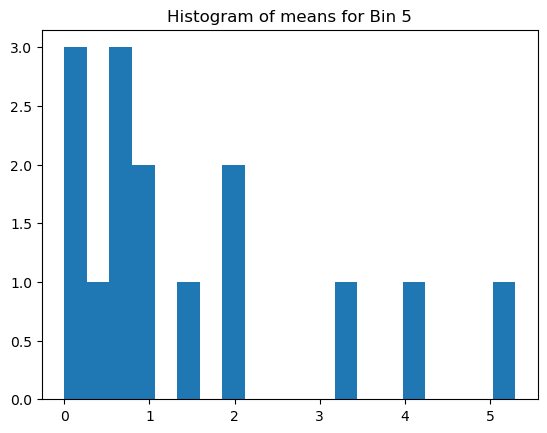

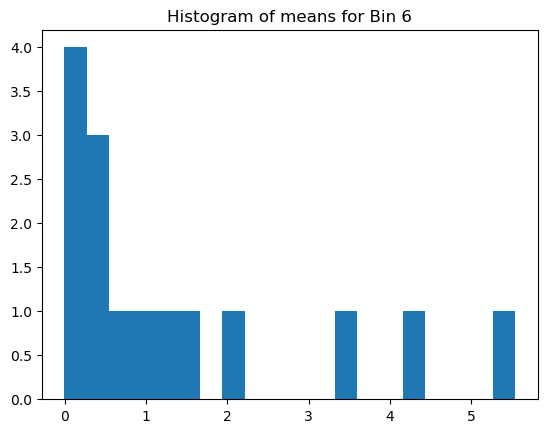

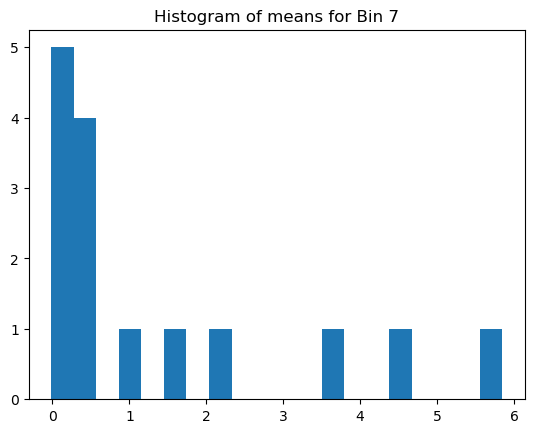

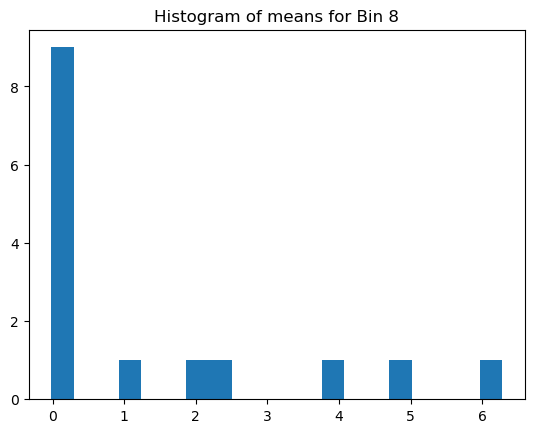

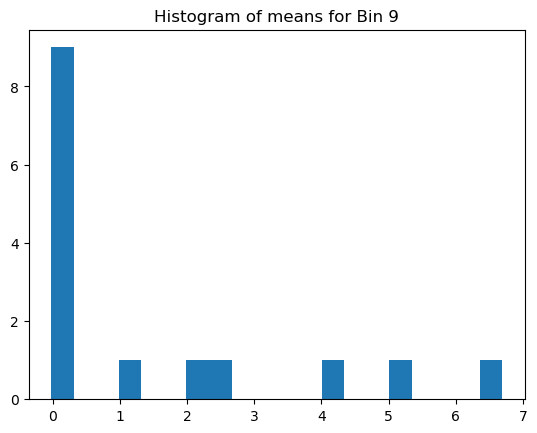

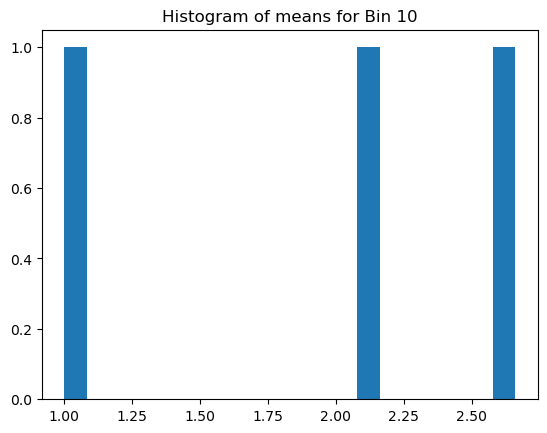

In [7]:
import matplotlib.pyplot as plt
for i in np.arange(len(mv['means'])):
    plt.figure()
    plt.hist(mv['means'][i], bins=20)
    plt.title(f'Histogram of means for Bin {i}')
    plt.show()

Now let's do the same for the covariance matrix

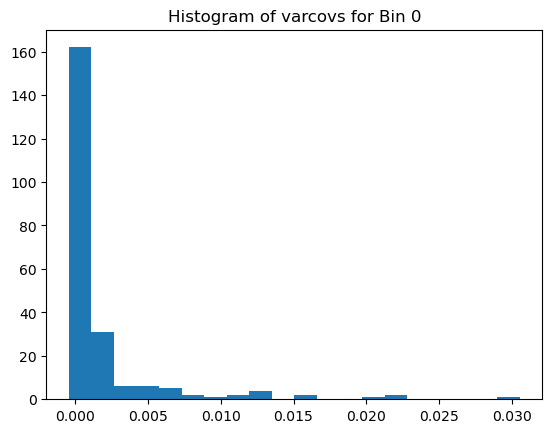

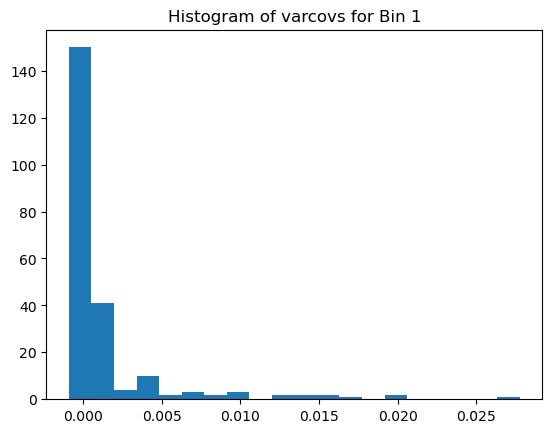

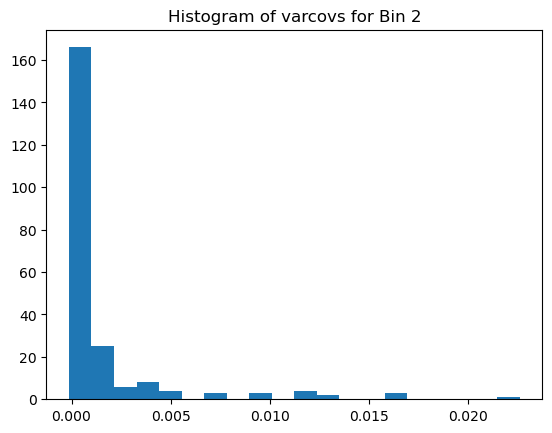

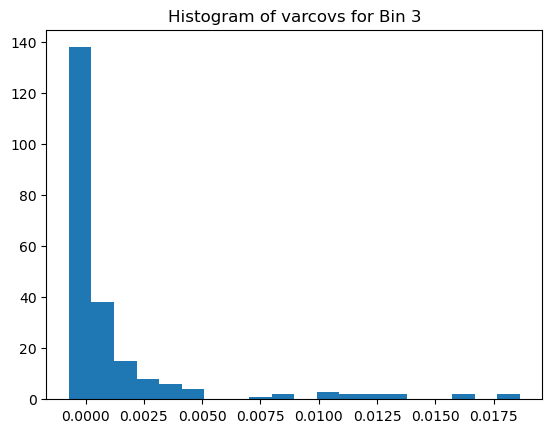

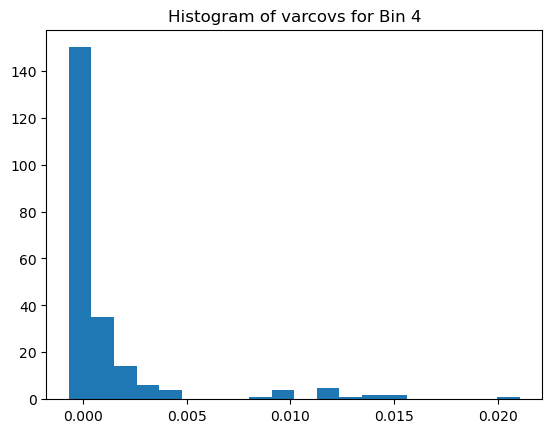

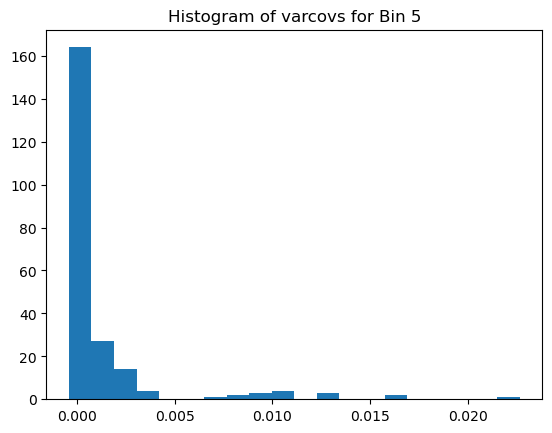

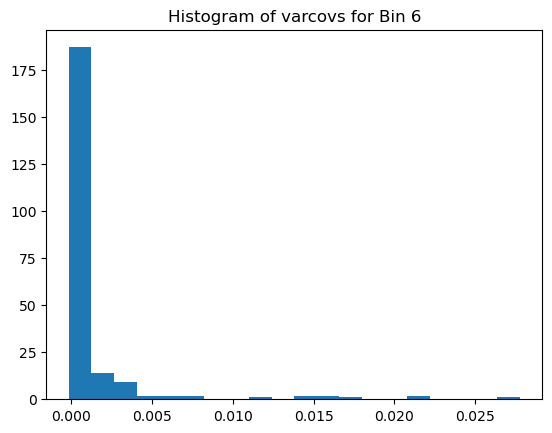

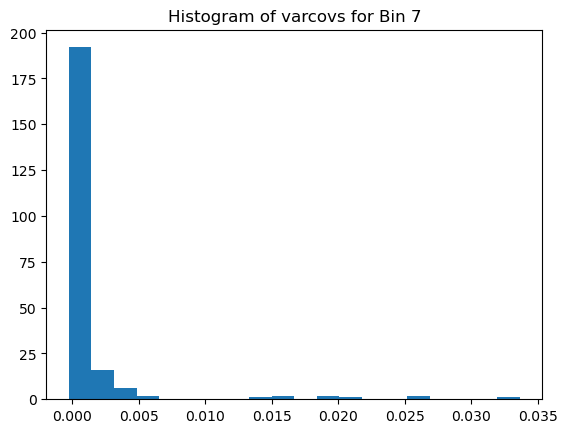

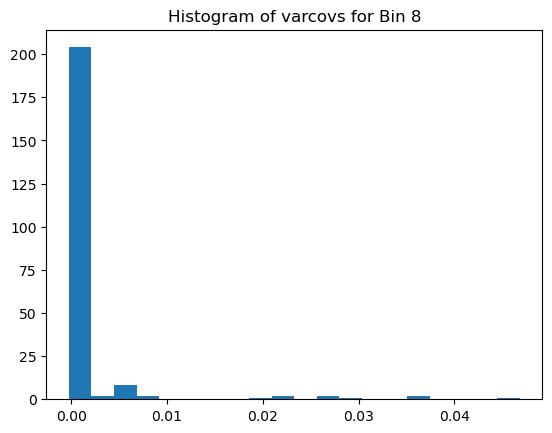

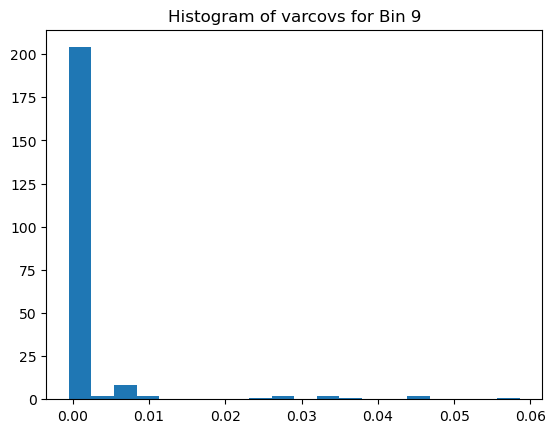

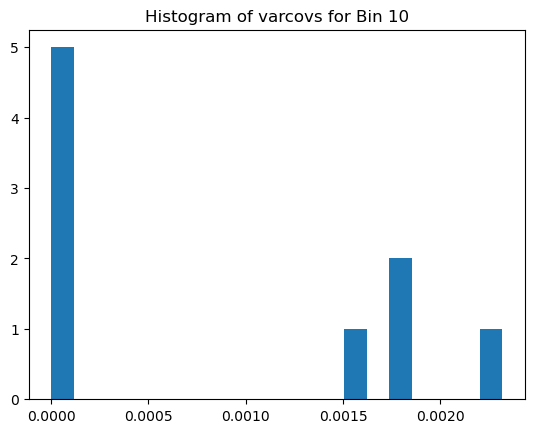

In [9]:
# covariance matrix histogram
for i in np.arange(len(mv['varcovs'])):
    plt.figure()
    plt.hist(mv['varcovs'][i].flatten(), bins=20)
    plt.title(f'Histogram of varcovs for Bin {i}')
    plt.show()

## My own implementation

In [13]:
import os
import time
import gzip
import numpy as np
import pickle
import msprime
import moments
import demes
import ray
import json

In [14]:
assert msprime.__version__ >= "1"

if not os.path.isdir("./data/"):
    os.makedirs("./data/")
os.system("rm ./data/*.vcf.gz")
os.system("rm ./data/*.h5")

rm: cannot remove './data/*.vcf.gz': No such file or directory
rm: cannot remove './data/*.h5': No such file or directory


256

In [15]:
upper_bound_params = {
    "t_split": 5000, 
    "m": 1e-4,
    "N1": 10000,
    "N2": 10000,
    "Na": 20000
}

lower_bound_params =  {
    "t_split": 100, 
    "m": 1e-8,
    "N1": 100,
    "N2": 100,
    "Na": 10000

}

In [16]:
def sample_params():
    sampled_params = {}
    for key in lower_bound_params:
        lower_bound = lower_bound_params[key]
        upper_bound = upper_bound_params[key]
        sampled_value = np.random.uniform(lower_bound, upper_bound)

        # Initialize adjusted_value with sampled_value by default
        adjusted_value = sampled_value

        # Check if the sampled parameter is equal to the mean of the uniform distribution
        mean_value = (lower_bound + upper_bound) / 2
        if sampled_value == mean_value:
            # Add a small random value to avoid exact mean, while keeping within bounds
            adjustment = np.random.uniform(-0.1 * (upper_bound - lower_bound), 0.1 * (upper_bound - lower_bound))
            adjusted_value = sampled_value + adjustment
            # Ensure the adjusted value is still within the bounds
            adjusted_value = max(min(adjusted_value, upper_bound), lower_bound)

        # Assign adjusted_value to sampled_params
        if key == "m":
            sampled_params[key] = adjusted_value
        else:
            sampled_params[key] = int(adjusted_value)

    return sampled_params

In [17]:
def demographic_model(sampled_params):

    # Unpack the sampled parameters
    Na, N1, N2, m, t_split = (
        sampled_params["Na"],  # Effective population size of the ancestral population
        sampled_params["N1"],  # Size of population 1 after split
        sampled_params["N2"],  # Size of population 2 after split
        sampled_params["m"],   # Migration rate between populations
        sampled_params["t_split"],  # Time of the population split (in generations)
    )

    b = demes.Builder()
    b.add_deme("Na", epochs=[dict(start_size=Na, end_time=t_split)])
    b.add_deme("N1", ancestors=["Na"], epochs=[dict(start_size=N1)])
    b.add_deme("N2", ancestors=["Na"], epochs=[dict(start_size=N2)])
    b.add_migration(demes=["N1", "N2"], rate=m)
    g = b.resolve()
    return g


In [18]:
def run_msprime_replicates(sampled_params, experiment_config, num_reps=100, L=1000000, u=1.5e-8, r=1.5e-8):

    g = demographic_model(sampled_params)
    demog = msprime.Demography.from_demes(g)
    tree_sequences = msprime.sim_ancestry(
        {"N1": experiment_config['num_samples']['N1'], "N2": experiment_config['num_samples']['N2']},
        demography=demog,
        sequence_length=experiment_config['genome_length'],
        recombination_rate=experiment_config['recombination_rate'],
        num_replicates=experiment_config['num_reps'],
        random_seed=experiment_config['seed'],
    )
    for ii, ts in enumerate(tree_sequences):
        ts = msprime.sim_mutations(ts, rate=u, random_seed=ii + 1)
        vcf_name = "./data/split_mig.{0}.vcf".format(ii)
        with open(vcf_name, "w+") as fout:
            ts.write_vcf(fout, allow_position_zero=True)
        os.system(f"gzip {vcf_name}")

In [19]:
def write_samples_and_rec_map(experiment_config):

    # Define the file paths
    samples_file = "./data/samples.txt"
    flat_map_file ="./data/flat_map.txt"

    # Open and write the sample file
    with open(samples_file, "w+") as fout:
        fout.write("sample\tpop\n")

        # Dynamically define samples based on the num_samples dictionary
        sample_idx = 0  # Initialize sample index
        for pop_name, sample_size in experiment_config['num_samples'].items():
            for _ in range(sample_size):
                fout.write(f"tsk_{sample_idx}\t{pop_name}\n")
                sample_idx += 1

    # Write the recombination map file
    with open(flat_map_file, "w+") as fout:
        fout.write("pos\tMap(cM)\n")
        fout.write("0\t0\n")
        fout.write(f"{experiment_config['genome_length']}\t{experiment_config['recombination_rate'] * experiment_config['genome_length'] * 100}\n")

In [20]:
# Define your function with Ray's remote decorator
@ray.remote
def get_LD_stats(rep_ii, r_bins):
    vcf_file = f"./data/split_mig.{rep_ii}.vcf.gz"
    time1 = time.time()
    ld_stats = moments.LD.Parsing.compute_ld_statistics(
        vcf_file,
        rec_map_file="./data/flat_map.txt",
        pop_file="./data/samples.txt",
        pops=["N1", "N2"],
        r_bins=r_bins,
        report=False,
    )
    time2 = time.time()
    print("  finished rep", rep_ii, "in", int(time2 - time1), "seconds")
    return ld_stats

In [21]:
if __name__ == "__main__":
    num_reps = 100
    # define the bin edges
    r_bins = np.array([0, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3])

    with open("/sietch_colab/akapoor/Demographic_Inference/experiment_config.json") as f:
        experiment_config = json.load(f)


    # Initialize Ray
    ray.init(ignore_reinit_error=True)

    # Sample parameters
    sampled_params = sample_params()

    print("running msprime and writing vcfs")
    run_msprime_replicates(sampled_params, experiment_config)
    # run_msprime_replicates(experiment_config=experiment_config, num_reps=num_reps)

    print("writing samples and recombination map")
    write_samples_and_rec_map(experiment_config=experiment_config)

    print("parsing LD statistics in parallel")
    # Submit tasks to Ray in parallel using .remote()
    futures = [get_LD_stats.remote(ii, r_bins) for ii in range(num_reps)]
    # Gather results with ray.get() to collect them once the tasks are finished
    ld_stats = ray.get(futures)
    # Optionally, you can convert the list of results into a dictionary with indices
    ld_stats_dict = {ii: result for ii, result in enumerate(ld_stats)}

    print("computing mean and varcov matrix from LD statistics sums")
    mv = moments.LD.Parsing.bootstrap_data(ld_stats_dict)
    with open(f"./data/means.varcovs.split_mig.{num_reps}_reps.bp", "wb+") as fout:
        pickle.dump(mv, fout)
    print(
        "computing bootstrap replicates of mean statistics (for confidence intervals"
    )
    all_boot = moments.LD.Parsing.get_bootstrap_sets(ld_stats_dict)
    with open(f"./data/bootstrap_sets.split_mig.{num_reps}_reps.bp", "wb+") as fout:
        pickle.dump(all_boot, fout)
    os.system("rm ./data/*.vcf.gz")
    os.system("rm ./data/*.h5")

    g = demographic_model(sampled_params)

    print("running inference")
    # Run inference using the parsed data
    demo_func = moments.LD.Demographics2D.split_mig
    # Set up the initial guess
    # The split_mig function takes four parameters (nu0, nu1, T, m), and we append
    # the last parameter to fit Ne, which doesn't get passed to the function but
    # scales recombination rates so can be simultaneously fit
    p_guess = [0.1, 2, 0.075, 2, 10000]
    p_guess = moments.LD.Util.perturb_params(p_guess, fold=0.1)
    opt_params, LL = moments.LD.Inference.optimize_log_lbfgsb(
        p_guess, [mv["means"], mv["varcovs"]], [demo_func], rs=r_bins,
    )

    physical_units = moments.LD.Util.rescale_params(
        opt_params, ["nu", "nu", "T", "m", "Ne"]
    )

    print("Simulated parameters:")
    print(f"  N(deme0)         :  {g.demes[1].epochs[0].start_size:.1f}")
    print(f"  N(deme1)         :  {g.demes[2].epochs[0].start_size:.1f}")
    print(f"  Div. time (gen)  :  {g.demes[1].epochs[0].start_time:.1f}")
    print(f"  Migration rate   :  {g.migrations[0].rate:.6f}")
    print(f"  N(ancestral)     :  {g.demes[0].epochs[0].start_size:.1f}")

    print("best fit parameters:")
    print(f"  N(deme0)         :  {physical_units[0]:.1f}")
    print(f"  N(deme1)         :  {physical_units[1]:.1f}")
    print(f"  Div. time (gen)  :  {physical_units[2]:.1f}")
    print(f"  Migration rate   :  {physical_units[3]:.6f}")
    print(f"  N(ancestral)     :  {physical_units[4]:.1f}")





2024-10-15 10:35:55,246	INFO worker.py:1614 -- Calling ray.init() again after it has already been called.


running msprime and writing vcfs
writing samples and recombination map
parsing LD statistics in parallel
computing mean and varcov matrix from LD statistics sums
computing bootstrap replicates of mean statistics (for confidence intervals
running inference
Simulated parameters:
  N(deme0)         :  199.0
  N(deme1)         :  6165.0
  Div. time (gen)  :  2755.0
  Migration rate   :  0.000070
  N(ancestral)     :  18663.0
best fit parameters:
  N(deme0)         :  1.6
  N(deme1)         :  325.8
  Div. time (gen)  :  4.5
  Migration rate   :  0.008037
  N(ancestral)     :  6836.8


In [1]:
import pickle
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_seed_42/sims/sims_pretrain_2_sims_inference_1_seed_42_num_replicates_10_top_values_5/simulation_results/software_inferences_sim_0.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data['simulated_params']

{'t_split': 4398, 'N1': 6647, 'N2': 8609, 'Na': 944, 'm': 0}

In [4]:
data['opt_params_momentsLD']

{'N1': 9630.4847057122,
 'N2': 11112.656100956929,
 't_split': 2880.544777334798,
 'm': 2.3887289546488923e-09,
 'Na': 305.67757773500995}

In [4]:
import pickle 
with open('/sietch_colab/akapoor/Demographic_Inference/split_isolation_model_dadi_analysis_True_moments_analysis_True_momentsLD_analysis_True_seed_42/sims/sims_pretrain_20_sims_inference_1_seed_42_num_replicates_3_top_values_2/preprocessing_results_obj.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
data['training']['predictions']

,Moments_rep1_Na,Moments_rep1_N1,Moments_rep1_N2,Moments_rep1_t_split,Moments_rep1_m,Moments_rep1_FIM_element_0,Moments_rep1_FIM_element_1,Moments_rep1_FIM_element_2,Moments_rep1_FIM_element_3,Moments_rep1_FIM_element_4,...,Dadi_rep2_Na,Dadi_rep2_N1,Dadi_rep2_N2,Dadi_rep2_t_split,Dadi_rep2_m,MomentsLD_N1,MomentsLD_N2,MomentsLD_t_split,MomentsLD_m,MomentsLD_Na
Sim_0,21112.439485,159.833039,9385.387931,5771.687435,4112.281243,-4.907393e+09,-1.383656e+05,2.249975e+05,-1.263158e+06,-942545.891755,...,14793.417999,258.950678,7299.776576,2.958684,1101.575686,7038.050741,6819.277799,1761.031508,0.000002,15197.338220
Sim_1,14893.308305,206.801364,7483.830946,2467.643413,902.426049,-3.055176e+09,2.168995e+05,-1.796326e+08,-2.637244e+08,-84832.524027,...,13198.095118,245.393432,9870.830102,889.903707,2332.296159,3678.049535,1532.624299,1693.330257,0.000002,15270.522749
Sim_2,17299.832158,93.819223,7926.575644,1378.614725,2344.053820,1.728992e+10,2.811045e+06,-7.628733e+09,-8.327025e+08,-403695.663927,...,13429.085536,112.961293,21149.861019,2.685817,1410.580881,5423.988086,7337.471393,299.603545,0.000002,14462.701681
Sim_3,18314.590698,119.627274,16784.302903,2122.992550,1048.935903,1.877295e+10,6.612261e+05,-4.227615e+09,-1.153892e+09,-56553.322367,...,15441.880022,206.305236,12660.736028,3.088376,2041.474113,9504.116260,8699.632792,3538.050891,0.000002,15140.103630
Sim_4,17247.124364,140.268207,9411.153296,1408.819922,1002.796158,-1.633327e+10,-9.968390e+05,1.012877e+09,-1.743030e+08,-243973.371336,...,16378.200267,114.393964,6636.159229,323.054448,1878.296990,5505.918547,10150.189089,3376.142390,0.000002,13050.977744
Sim_5,19067.070138,148.210334,26212.131849,2715.285980,997.936631,2.265836e+10,9.804823e+05,-4.407385e+09,-1.525762e+09,-29567.501059,...,16964.211959,244.781437,22018.619059,3.392842,2693.690151,35.359778,26.079385,1.095955,0.000002,19426.230490
Sim_6,15580.919976,220.899263,12524.524319,1945.504280,779.606914,-5.921458e+09,-6.129035e+05,4.571720e+08,-9.255619e+07,-28826.627694,...,15337.390456,152.324784,8463.419293,408.223632,1321.054388,5828.168517,2521.989184,1993.555848,0.000002,15932.713201
Sim_7,14745.342069,76.432879,8755.957360,2922.506387,979.935560,-5.251242e+09,3.782126e+04,0.000000e+00,0.000000e+00,-335433.380523,...,13246.518258,229.825593,7022.120561,334.967993,1994.462224,2293.501704,9089.698203,2399.750794,0.000002,12064.679844
Sim_8,23155.467015,136.693765,11710.013030,4916.543875,3635.141128,-7.375966e+09,-2.339712e+05,-7.430167e+05,-1.507400e+06,-586297.899949,...,20268.189670,333.767280,10208.050711,679.283155,1173.498749,4481.245760,7829.912082,4231.195936,0.000002,20650.946412
Sim_9,12131.799863,88.532501,13128.454184,1137.617629,732.196212,-8.341872e+09,-2.800902e+05,-3.885596e+08,-3.367440e+08,-9145.790713,...,11744.060260,210.280118,9411.527620,225.403146,1229.296066,4572.561258,4280.818480,4019.742504,0.000002,12163.705507
